clang: warning: libstdc++ is deprecated; move to libc++ with a minimum deployment target of OS X 10.9 [-Wdeprecated]
ld: library not found for -lstdc++
clang: error: linker command failed with exit code 1 (use -v to see invocation)
WARNING    Cannot use Cython, a test compilation failed: command 'g++' failed with exit status 1 (LinkError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


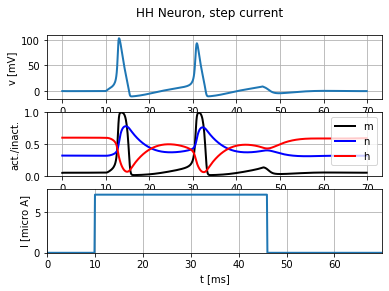

In [1]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex.hodgkin_huxley import HH
from neurodynex.tools import input_factory

HH.getting_started()

# 6.1.1-2
Not sure why values between 2.29 and 6.25 generate non-periodic spikes. Something about the recovery time of the activation variables? If that's the case, then maybe longer stim would trigger a second spike.
- ran it for 500ms, does not seem to be the case. 
### Why??

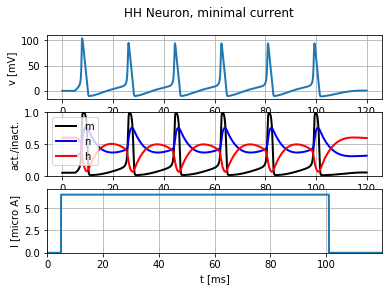

In [64]:
# single spike: ~2.29uA
# repetitive spiking: ~6.25uA for more than 2 spikes

I_min = 6.5
current = input_factory.get_step_current(5, 100, b2.ms, I_min *b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 120 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, minimal current")

# 6.2.1-3

voltage_slow=0.010362508767102145


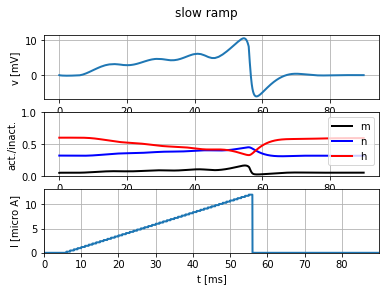

In [88]:
b2.defaultclock.dt = 0.02*b2.ms
slow_ramp_t_end = 55  # no spike. make it shorter
slow_ramp_current = input_factory.get_ramp_current(5, slow_ramp_t_end, b2.ms, 0.*b2.uA, 12.0*b2.uA)
state_monitor = HH.simulate_HH_neuron(slow_ramp_current, 90 * b2.ms)
idx_t_end = int(round(slow_ramp_t_end*b2.ms / b2.defaultclock.dt))
voltage_slow = state_monitor.vm[0,idx_t_end]
print("voltage_slow={}".format(voltage_slow))
HH.plot_data(state_monitor, title="slow ramp")

voltage_slow=0.0031472907111491275


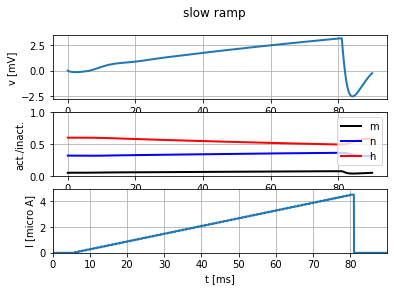

In [93]:
b2.defaultclock.dt = 0.02*b2.ms
slow_ramp_t_end = 80  # no spike. make it shorter
slow_ramp_current = input_factory.get_ramp_current(5, slow_ramp_t_end, b2.ms, 0.*b2.uA, 4.5*b2.uA)
state_monitor = HH.simulate_HH_neuron(slow_ramp_current, 90 * b2.ms)
idx_t_end = int(round(slow_ramp_t_end*b2.ms / b2.defaultclock.dt))
voltage_slow = state_monitor.vm[0,idx_t_end]
print("voltage_slow={}".format(voltage_slow))
HH.plot_data(state_monitor, title="slow ramp")

In [56]:
HH.simulate_HH_neuron

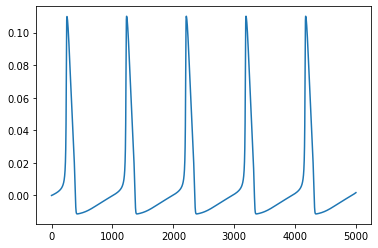

In [95]:
simulation_time = 100*b2.ms
input_current = input_factory.get_step_current(10, 20, b2.ms, 0*b2.uA)

# neuron parameters
El = 10.6 * b2.mV
EK = -12 * b2.mV
ENa = 115 * b2.mV
gl = 0.3 * b2.msiemens
gK = 36 * b2.msiemens
gNa = 2*120 * b2.msiemens
C = 1 * b2.ufarad

# forming HH model with differential equations
eqs = """
    I_e = input_current(t,i) : amp
    membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
        gl*(El-vm) + gK*n**4*(EK-vm) : amp
    alphah = .07*exp(-.05*vm/mV)/ms    : Hz
    alpham = .1*(25*mV-vm)/(exp(2.5-.1*vm/mV)-1)/mV/ms : Hz
    alphan = .01*(10*mV-vm)/(exp(1-.1*vm/mV)-1)/mV/ms : Hz
    betah = 1./(1+exp(3.-.1*vm/mV))/ms : Hz
    betam = 4*exp(-.0556*vm/mV)/ms : Hz
    betan = .125*exp(-.0125*vm/mV)/ms : Hz
    dh/dt = alphah*(1-h)-betah*h : 1
    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dvm/dt = membrane_Im/C : volt
"""

neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

# parameter initialization
neuron.vm = 0
neuron.m = 0.05
neuron.h = 0.60
neuron.n = 0.32

# tracking parameters
st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "m", "n", "h"], record=True)

# running the simulation
hh_net = b2.Network(neuron)
hh_net.add(st_mon)
hh_net.run(simulation_time)

plt.plot(st_mon.vm[0])